# Constructing a DBR

In [1]:
import meep as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter 

In [2]:
import math
from meep.materials import Au
from meep.materials import Ag
from meep.materials import SiO2
from meep.materials import BK7

### DBR construction with n layers (alternating TiO2 and SiO2)

In [6]:
um_scale = 1
TiO2_range = mp.FreqRange(min=um_scale/1.77, max=um_scale/0.25)

TiO2_frq1 = 1/(0.250*um_scale)
TiO2_gam1 = 1/(25*um_scale)
TiO2_sig1 = 3.9 #2.12

TiO2_susc = [mp.LorentzianSusceptibility(frequency=TiO2_frq1, gamma=TiO2_gam1, sigma=TiO2_sig1)]

TiO2_ = mp.Medium(epsilon=1.0, E_susceptibilities=TiO2_susc, valid_freq_range=TiO2_range)

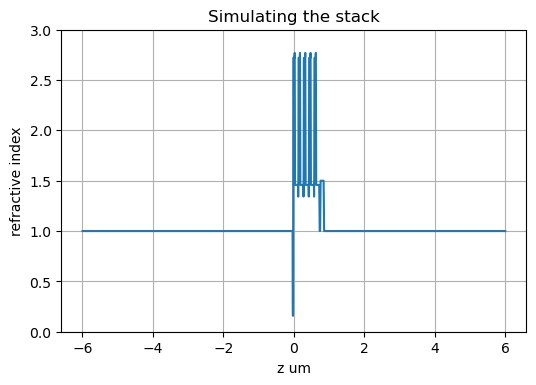

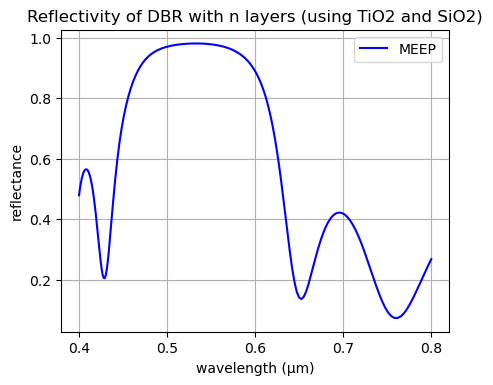

In [9]:
resolution = 200 
dpml = 1.0                         # Thickness of PML layer
sz = 10 + 2*dpml                   # 10 units for the material then PML on the sides
cell_size = mp.Vector3(z=sz)       # With just 1 argument is a 1D cell 12 microns long
pml_layers = [mp.PML(dpml)]        # Make the PML layers, note the brackets as it is a list

# Wavelengths
wvl_min = 0.4                      # Implied units of microns
wvl_max = 0.8                      # so 400-800 nm

# frequencies
fmin = 1/wvl_max                   # Implicit assumption that c = 1
fmax = 1/wvl_min

# These quantities are needed for the flux monitor
fcen = 0.5*(fmax + fmin)
df = fmax - fmin
nfreq = 200                         # Sample 50 frequecies in the range

# Make a Gaussian source at the center frequency, spanning the frequency range
# Specify its polarization as along x (Ex is the only allowed direction for a 1D model)
# It is located at the LH edge of the cell
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), 
                     component=mp.Ex, 
                     center=mp.Vector3(z=-0.5*sz+dpml))]  # at z = -5

# Set up a 1D simulation - for the empty cell  
# dimensions are set to 1 because the default is 3 (or 2 if you just have an xy cell)
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions=1,
                    resolution=resolution)

# (1) define location of flux monitor (flux region) and (2) add it to simulation
# flux monitor will be on the surface of the absorber at z = -3
refl_fr = mp.FluxRegion(center=mp.Vector3(z=-0.25*sz))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# Run the simulation of the empty cell until Ex at center decays to 1e-9
mp.quiet(quietval=True)                  # writing messages or not
sim.progress_interval = 10               # stdin reporting, default is 4 seconds
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(), 1e-9))

# get_fluxes by frequency and get the complex E and H values  
empty_flux = mp.get_fluxes(refl)          # by frequency, used to compute reflectivity
empty_data = sim.get_flux_data(refl)      # complex E and H values, subtracted later so
                                          #   that the reflected wave can be considered 
                                          #   separately

# reset simulation for the run with the material in it
sim.reset_meep()

n_pairs=5
geometry = []
t1 = 0.05
t2 = 0.1
t3 = 0.005
t4 = 0.1
x = (t1/2) + (t2/2)

for i in range(0,n_pairs):
    geometry.extend([mp.Block(mp.Vector3(mp.inf, mp.inf, t2), 
                     center=mp.Vector3(z=(2*i*x)+x), 
                     material=SiO2),
            
            mp.Block(mp.Vector3(mp.inf, mp.inf, t1), 
                     center=mp.Vector3(z=2*i*x), 
                     material=TiO2_)])
    

geometry.extend([mp.Block(mp.Vector3(mp.inf, mp.inf, t3), 
                     center=mp.Vector3(z=-(t1/2)-(t3/2)), 
                     material=Ag)])

geometry.extend([mp.Block(mp.Vector3(mp.inf, mp.inf, t4), 
                     center=mp.Vector3(z=(2*n_pairs*x)+(t4/2)), 
                     material=glass)])


# Set up the simulation for the filled cell
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    dimensions=1,
                    resolution=resolution)


# Make a new flux monitor for the reflected wave, subtract the transmitted wave
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
sim.load_minus_flux_data(refl, empty_data)

# Run the filled simulation
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(), 1e-9))

# Get reflected flux and compute reflectivity
refl_flux = mp.get_fluxes(refl)              # one entry per frequency
R_meep = -1*np.divide(refl_flux,empty_flux)

# get the frequencies used in the simulation, convert to wavelengths for plotting
freqs = mp.get_flux_freqs(refl)
wvls = np.divide(1,freqs)

plt.figure(dpi=100)
plt.title('Simulating the stack')
plt.plot(sim.get_array_metadata(center=mp.Vector3(),size=cell_size)[2],np.real(np.sqrt(sim.get_epsilon(fmax))),label='n')
#plt.xlim(-1,1)
plt.ylim(0,3)
plt.xlabel('z um')
plt.ylabel('refractive index')
plt.grid()
plt.show

#  Make the plot
plt.figure(figsize=(5,4), dpi=100)
plt.title('Reflectivity of DBR with n layers (using TiO2 and SiO2)')
plt.plot(wvls,R_meep, 'b-', label='MEEP')
#plt.plot(wvls,R_analytic, 'r', label='Sellmeier equation')
plt.xlabel("wavelength (μm)")
plt.ylabel("reflectance")
#plt.axis([0.4, 0.8, 0.0340, 0.0365])
plt.xticks([t for t in np.arange(0.4,0.9,0.1)])
plt.legend(loc='upper right')
plt.grid()
plt.show()
